In [1]:
import pandas as pd
import numpy as np
import glob
import os
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering
import matplotlib.font_manager as fm
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

CUSTOM_FONT_PATH     = "/content/drive/MyDrive/lmroman10-regular.otf" #r"lmroman10-regular.otf"
CUSTOM_FONT_NAME     = "Latin Modern Roman"

if CUSTOM_FONT_PATH:
    fm.fontManager.addfont(CUSTOM_FONT_PATH)
    plt.rcParams['font.family'] = CUSTOM_FONT_NAME

Mounted at /content/drive


In [3]:
# Set path to your CSV files
csv_dir = "/content/drive/MyDrive/8K60FPS_Link/60sec/Analysis/video_complixity/*.csv"  # 8K60FPS_Link is a shortcut folder to the VEDIA dataset

# Get sorted list of CSV files
all_files = sorted(glob.glob(csv_dir))

# Initialize list to store DataFrames
dfs = []

for file in all_files:
    try:
        if 'vmaf' in file:
            continue
        # Extract video number from filename (assuming format: 000_videoname.csv)
        filename = os.path.basename(file)
        video_number = int(filename.split('_')[0])  # First part is numeric

        # Read CSV and add video number column
        df = pd.read_csv(file)
        df['video_number'] = video_number
        df['video_id'] = f"{video_number:03d}_10s"


        dfs.append(df)

    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Optional: Verify results
print(f"Combined DataFrame shape: {combined_df.shape}")
print("Number of unique videos:", len(combined_df['video_number'].unique()))

Combined DataFrame shape: (108000, 23)
Number of unique videos: 30


In [4]:
# viewing loaded data
combined_df.head(10)

,Frame,SI,TI,Contrast,Sharpness,Blockiness,TextureComplexity,ColorVar_U,ColorVar_V,Colorfulness,...,EntropyDiff,MotionIntensityDiff,EdgeDirectionality,AvgMotionXAxis,AvgMotionYAxis,StdMotionXAxis,StdMotionYAxis,video_number,video_id,ColorDominance
0,0,116.8471,0.0000,159.250,657.00,109.2500,0.4913,884.0,315.00,40.5938,...,0.0000,0.0000,4.1541,0.0000,0.0000,0.0000,0.0000,0,000_10s,NaN
1,1,116.6777,8.3750,159.125,586.50,108.6250,0.4510,875.0,309.00,40.4375,...,0.0035,4.7852,4.1530,0.0226,0.0116,0.1462,0.0792,0,000_10s,NaN
2,2,116.7707,8.8281,159.125,548.00,108.1875,0.4223,869.5,304.50,40.3125,...,0.0017,4.8867,4.1518,0.0414,-0.1024,0.1680,0.0923,0,000_10s,NaN
3,3,116.8775,7.7109,159.125,519.00,107.9375,0.3954,865.0,300.75,40.1875,...,0.0011,3.9941,4.1508,0.1462,0.0065,0.1620,0.0865,0,000_10s,NaN
4,4,117.0946,7.3164,159.125,528.50,108.0000,0.3987,863.5,297.75,40.1250,...,0.0004,3.8145,4.1508,0.0503,0.0394,0.1743,0.0968,0,000_10s,NaN
5,5,117.2313,7.3398,159.125,527.00,107.9375,0.3972,861.0,295.00,40.0312,...,0.0003,3.8848,4.1508,0.0131,0.0746,0.1705,0.1107,0,000_10s,NaN
6,6,117.0873,7.1094,159.125,522.50,107.8750,0.3958,859.5,292.00,39.9375,...,0.0000,3.7109,4.1508,0.0177,0.0244,0.1495,0.0718,0,000_10s,NaN
7,7,116.6497,7.2227,159.000,507.25,107.7500,0.3889,858.5,289.00,39.8438,...,0.0013,3.8203,4.1505,0.0112,0.0753,0.1697,0.0706,0,000_10s,NaN
8,8,116.1914,7.2109,159.000,503.50,107.7500,0.3914,857.0,286.50,39.7500,...,0.0011,3.8105,4.1510,0.0558,0.0735,0.1364,0.0636,0,000_10s,NaN
9,9,115.5817,8.5156,159.000,479.50,107.6250,0.3819,854.0,283.00,39.6250,...,0.0011,4.5977,4.1506,0.0056,0.1293,0.1815,0.0681,0,000_10s,NaN


In [5]:
# Custom aggregation functions
def linear_trend(s):
    x = np.arange(len(s))
    return np.polyfit(x, s, 1)[0] if len(s) > 1 else np.nan

def entropy(s):
    return skew(s) * kurtosis(s)  # Custom complexity measure

# Define the columns you want to keep

columns_to_use = [
 'SI',
 'TI',
 'TextureComplexity',
 'Colorfulness',
 'Entropy',
 'AvgMotionXAxis',
 'AvgMotionYAxis',
 'video_number'
]

# Filter the DataFrame
filtered_df = combined_df[columns_to_use].copy()

# Confirm 'video_number' is present
assert 'video_number' in filtered_df.columns

# Define numeric columns (excluding 'video_number')
numeric_cols = filtered_df.select_dtypes(include=np.number).columns.difference(['video_number']).tolist()


# Define comprehensive aggregations
def safe_skew(x):
    if len(x) < 3 or x.std() < 1e-8:
        return np.nan
    return skew(x, bias=False)

def safe_kurtosis(x):
    if len(x) < 4 or x.std() < 1e-8:
        return np.nan
    return kurtosis(x, bias=False)

def stabilized_entropy(x):
    hist = np.histogram(x, bins='auto')[0].astype(float)
    hist += 1e-12  # Prevent zero probabilities
    hist /= hist.sum()
    return -np.sum(hist * np.log(hist))

def safe_hurst(x):
    if len(x) < 10 or np.std(x) < 1e-8:
        return np.nan
    return np.log(np.std(x) + 1e-12) / np.log(len(x))

def robust_autocorr(x):
    if len(x) < 2 or x.std() < 1e-8:
        return np.nan
    return x.autocorr(lag=1)

# Create the aggregation dictionary
agg_config = {
    col: [
        ('mean', lambda x: np.nanmean(x)),
        ('std', lambda x: np.nanstd(x)),
        ('range', lambda x: np.nanmax(x) - np.nanmin(x)),
        ('skew', safe_skew),
        ('kurt', safe_kurtosis),
        ('median', lambda x: np.nanmedian(x)),
        ('mad', lambda x: np.nanmean(np.abs(x - np.nanmean(x)))),
        ('trend', linear_trend),
        ('autocorr', robust_autocorr),
        ('fft1', lambda x: np.abs(np.fft.fft(x.fillna(0).values)[1]) if len(x) > 1 else np.nan),
        ('hurst', safe_hurst),
        ('nonlin', lambda x: np.nanmean(np.diff(x)**2))
    ]
    for col in numeric_cols
}

# Perform aggregation
agg_features = filtered_df.groupby('video_number').agg(agg_config)


# Flatten column names
agg_features.columns = [f"{col}_{stat}" for col, stat in agg_features.columns]

# Clean and clip the data
agg_features = agg_features.replace([np.inf, -np.inf], np.nan)
agg_features = agg_features.fillna(agg_features.mean())
agg_features = agg_features.clip(lower=agg_features.quantile(0.01),
                                 upper=agg_features.quantile(0.99), axis=1)


In [6]:
# viewing aggergated data
agg_features.head(10)

,AvgMotionXAxis_mean,AvgMotionXAxis_std,AvgMotionXAxis_range,AvgMotionXAxis_skew,AvgMotionXAxis_kurt,AvgMotionXAxis_median,AvgMotionXAxis_mad,AvgMotionXAxis_trend,AvgMotionXAxis_autocorr,AvgMotionXAxis_fft1,...,TextureComplexity_range,TextureComplexity_skew,TextureComplexity_kurt,TextureComplexity_median,TextureComplexity_mad,TextureComplexity_trend,TextureComplexity_autocorr,TextureComplexity_fft1,TextureComplexity_hurst,TextureComplexity_nonlin
video_number,,,,,,,,,,,,,,,,,,,,,
0,4.734245,10.116013,54.757800,2.404025,5.086532,0.040700,6.886712,0.004788,0.982825,15224.692100,...,0.414300,0.566269,-1.569541,0.098500,0.121549,1.021660e-05,0.999016,274.739715,-0.250960,0.000032
1,0.196220,1.190468,22.070300,-1.899405,30.678216,0.181750,0.509229,-0.000019,0.957247,55.930416,...,0.243100,-0.599805,0.264683,0.748503,0.029699,1.810566e-05,0.994738,66.853077,-0.397765,0.000016
2,-0.056095,1.009215,10.878900,-0.870084,7.765009,0.041300,0.555156,-0.000129,0.992630,399.357815,...,0.107700,-1.519290,2.478717,0.214800,0.014170,-9.944924e-06,0.997371,12.984287,-0.479616,0.000002
3,0.017264,0.054112,1.652900,-2.136255,73.384037,0.017700,0.031299,-0.000005,0.678371,11.664256,...,0.131600,1.792378,15.491604,0.452350,0.006972,6.014588e-06,0.851240,15.550108,-0.577413,0.000022
4,0.023443,0.047170,0.463400,0.003252,1.082342,0.022900,0.036356,0.000001,0.613367,3.630412,...,0.104400,1.976342,5.070371,0.675600,0.009583,6.353369e-06,0.978489,20.337383,-0.528485,0.000007
5,-0.044106,0.440941,11.986400,-4.784616,67.689389,0.034200,0.220359,-0.000100,0.665039,228.796724,...,0.706354,0.198345,-1.108812,0.416700,0.149334,-5.432491e-05,0.995513,139.272086,-0.209380,0.000332
6,0.009280,0.031846,0.283983,-0.163575,0.291880,0.009600,0.025304,0.000001,0.006804,2.515961,...,0.056300,0.320913,5.079823,0.303300,0.003108,-4.974717e-07,0.716094,0.905978,-0.674155,0.000011
7,1.968738,4.755727,30.918500,2.655890,6.883861,0.013450,3.189816,0.002655,0.992660,6613.958543,...,0.488600,-0.171000,-0.844421,0.255100,0.118330,-9.487335e-05,0.996330,243.627652,-0.243050,0.000137
8,-2.230702,26.120768,261.652470,-0.095541,15.733131,-1.321335,11.345197,0.000090,0.996943,26829.782298,...,0.353700,0.424240,0.133161,0.191700,0.056988,2.015301e-05,0.994590,6.860854,-0.323743,0.000054


In [7]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(agg_features)
features_scaled_df = pd.DataFrame(features_scaled, columns=agg_features.columns)

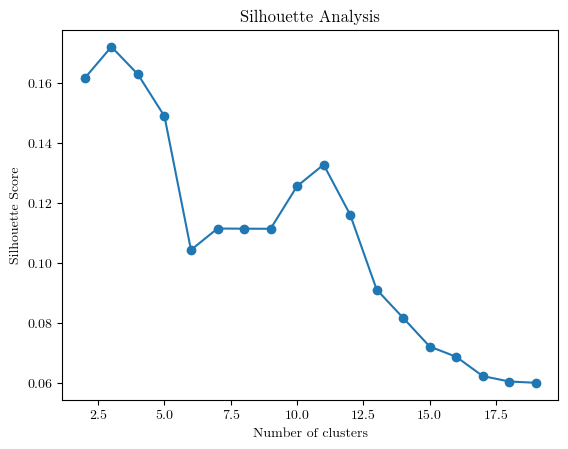

In [8]:
sil_scores = []
K_range = range(2, 20)

for k in K_range:
    model = AgglomerativeClustering(n_clusters=k).fit(features_scaled)
    labels = model.fit_predict(features_scaled)
    sil = silhouette_score(features_scaled, labels)
    sil_scores.append(sil)

plt.plot(K_range, sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


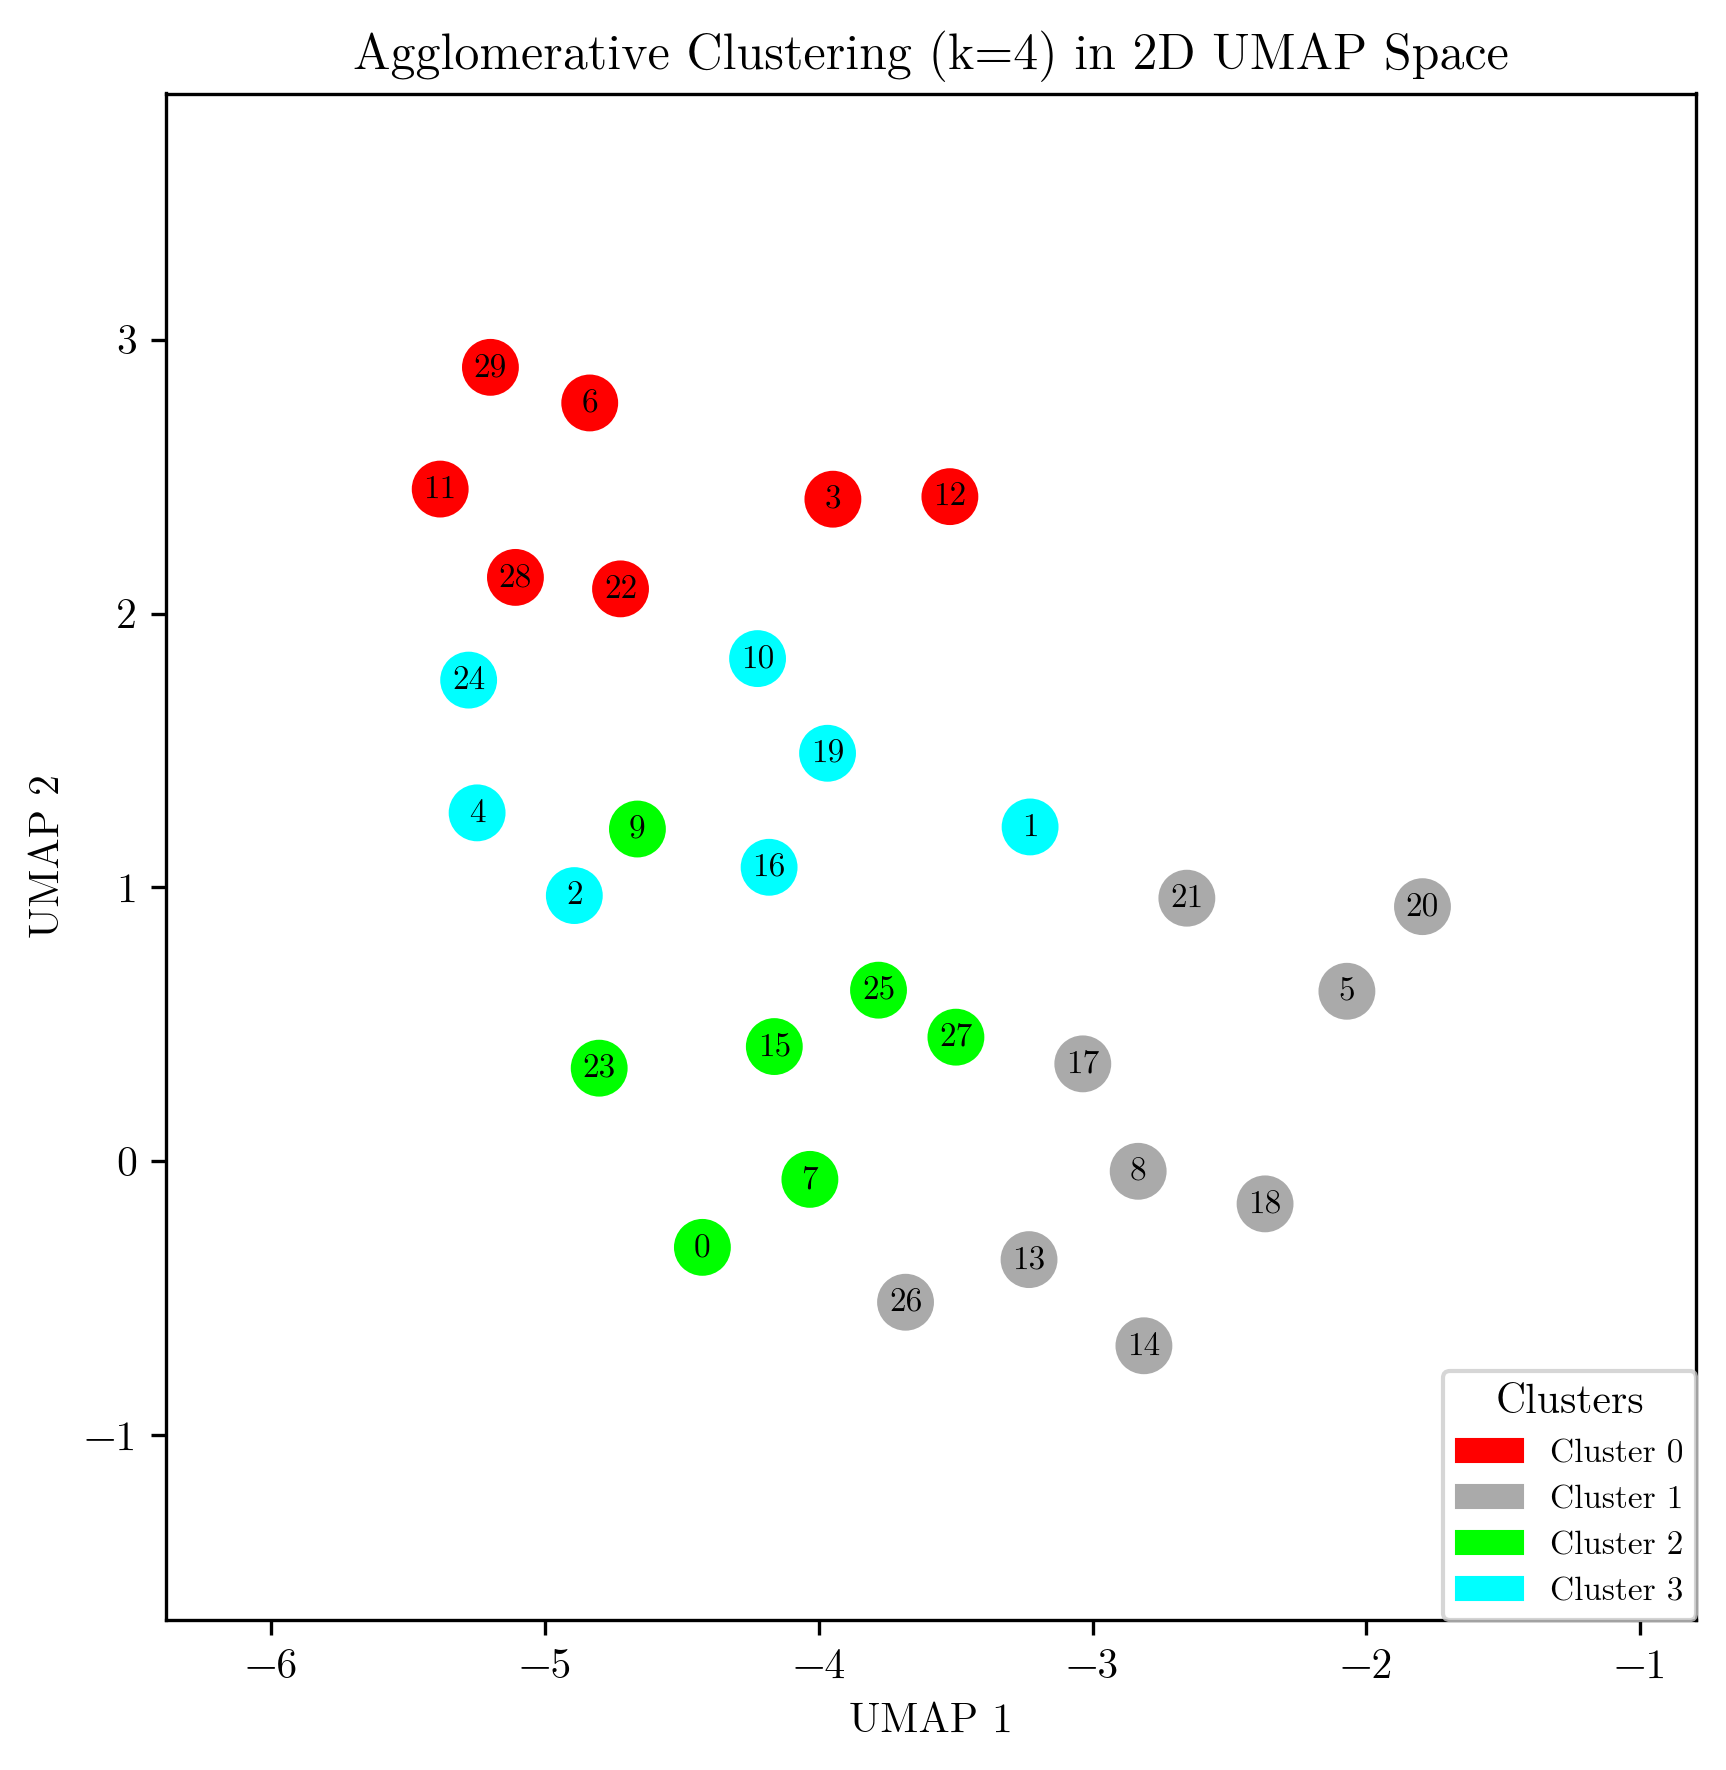

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
import umap
from sklearn.cluster import AgglomerativeClustering
from matplotlib.patches import Patch


# Step 1: Reduce dimensions for clustering
umap_reducer = umap.UMAP(n_components=10, random_state=0)
features_reduced = umap_reducer.fit_transform(features_scaled)

# Step 2: Perform clustering
final_k = 4
model = AgglomerativeClustering(n_clusters=final_k)
labels = model.fit_predict(features_reduced)

# Step 3: UMAP again for 2D visualization
umap_2d = umap.UMAP(n_components=2, random_state=0)
X_2d = umap_2d.fit_transform(features_scaled)

# Base 5-color palette (RYGCB)
base_colors = ['#FF0000', '#AAAAAA', '#00FF00', '#00FFFF', '#AA00FF']
fill_styles = ['solid', 'hatch1', 'hatch2']
hatch_patterns = {'solid': None,
                  'hatch1': '/////',
                  'hatch2': 'xxxx'}

# Define plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot each point with pattern + color
for i in range(len(X_2d)):
    label = labels[i]
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]

    x, y = X_2d[i]
    circle = Circle((x, y), radius=0.1,
                    facecolor=color if hatch is None else 'white',
                    edgecolor=color,
                    hatch=hatch,
                    linewidth=.5,
                    alpha=1)
    ax.add_patch(circle)

    video_id = agg_features.index[i]
    ax.text(x, y, str(video_id), fontsize=8, ha='center', va='center', color='black')

# Axis settings
ax.set_title(f'Agglomerative Clustering (k={final_k}) in 2D UMAP Space')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_xlim(X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1)
ax.set_ylim(X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1)
ax.set_aspect('equal')

# Legend setup
legend_elements = []
for label in np.unique(labels):
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]

    legend_elements.append(Patch(
        facecolor=color if hatch is None else 'white',
        edgecolor=color,
        hatch=hatch,
        label=f'Cluster {label}',
        linewidth=0.5
    ))

legend = ax.legend(
    handles=legend_elements,
    title='Clusters',
    # bbox_to_anchor=(1.01, 1),
    fontsize=8,
    loc='lower right',
    borderaxespad=0.,
    handletextpad=0.8
)

# Set all legend text to black for consistency
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Start with a DataFrame that includes video numbers and their assigned clusters
video_cluster_df = pd.DataFrame({
    'video_number': agg_features.index,
    'cluster': labels
})

# Stratified split by cluster
train_videos, test_videos = train_test_split(
    video_cluster_df,
    test_size=0.2,
    stratify=video_cluster_df['cluster'],
    random_state=0
)
train_video_ids = train_videos['video_number'].values
test_video_ids = test_videos['video_number'].values

In [14]:
print("Training video IDs:", train_video_ids)
print("Testing video IDs:", test_video_ids)
print("Number of training videos:", len(train_video_ids))
print("Number of testing videos", len(test_video_ids))
print("Train/Test ratio:", 100*len(train_video_ids) / (len(train_video_ids)+len(test_video_ids)), ":", 100*len(test_video_ids) / (len(train_video_ids)+len(test_video_ids)))

Training video IDs: [ 9 17  5  2  6 20  8 19 10 12  7 25 26 11 24 21 15  0 22  4 29 16 23 14]
Testing video IDs: [18 13 28 27  1  3]
Number of training videos: 24
Number of testing videos 6
Train/Test ratio: 80.0 : 20.0


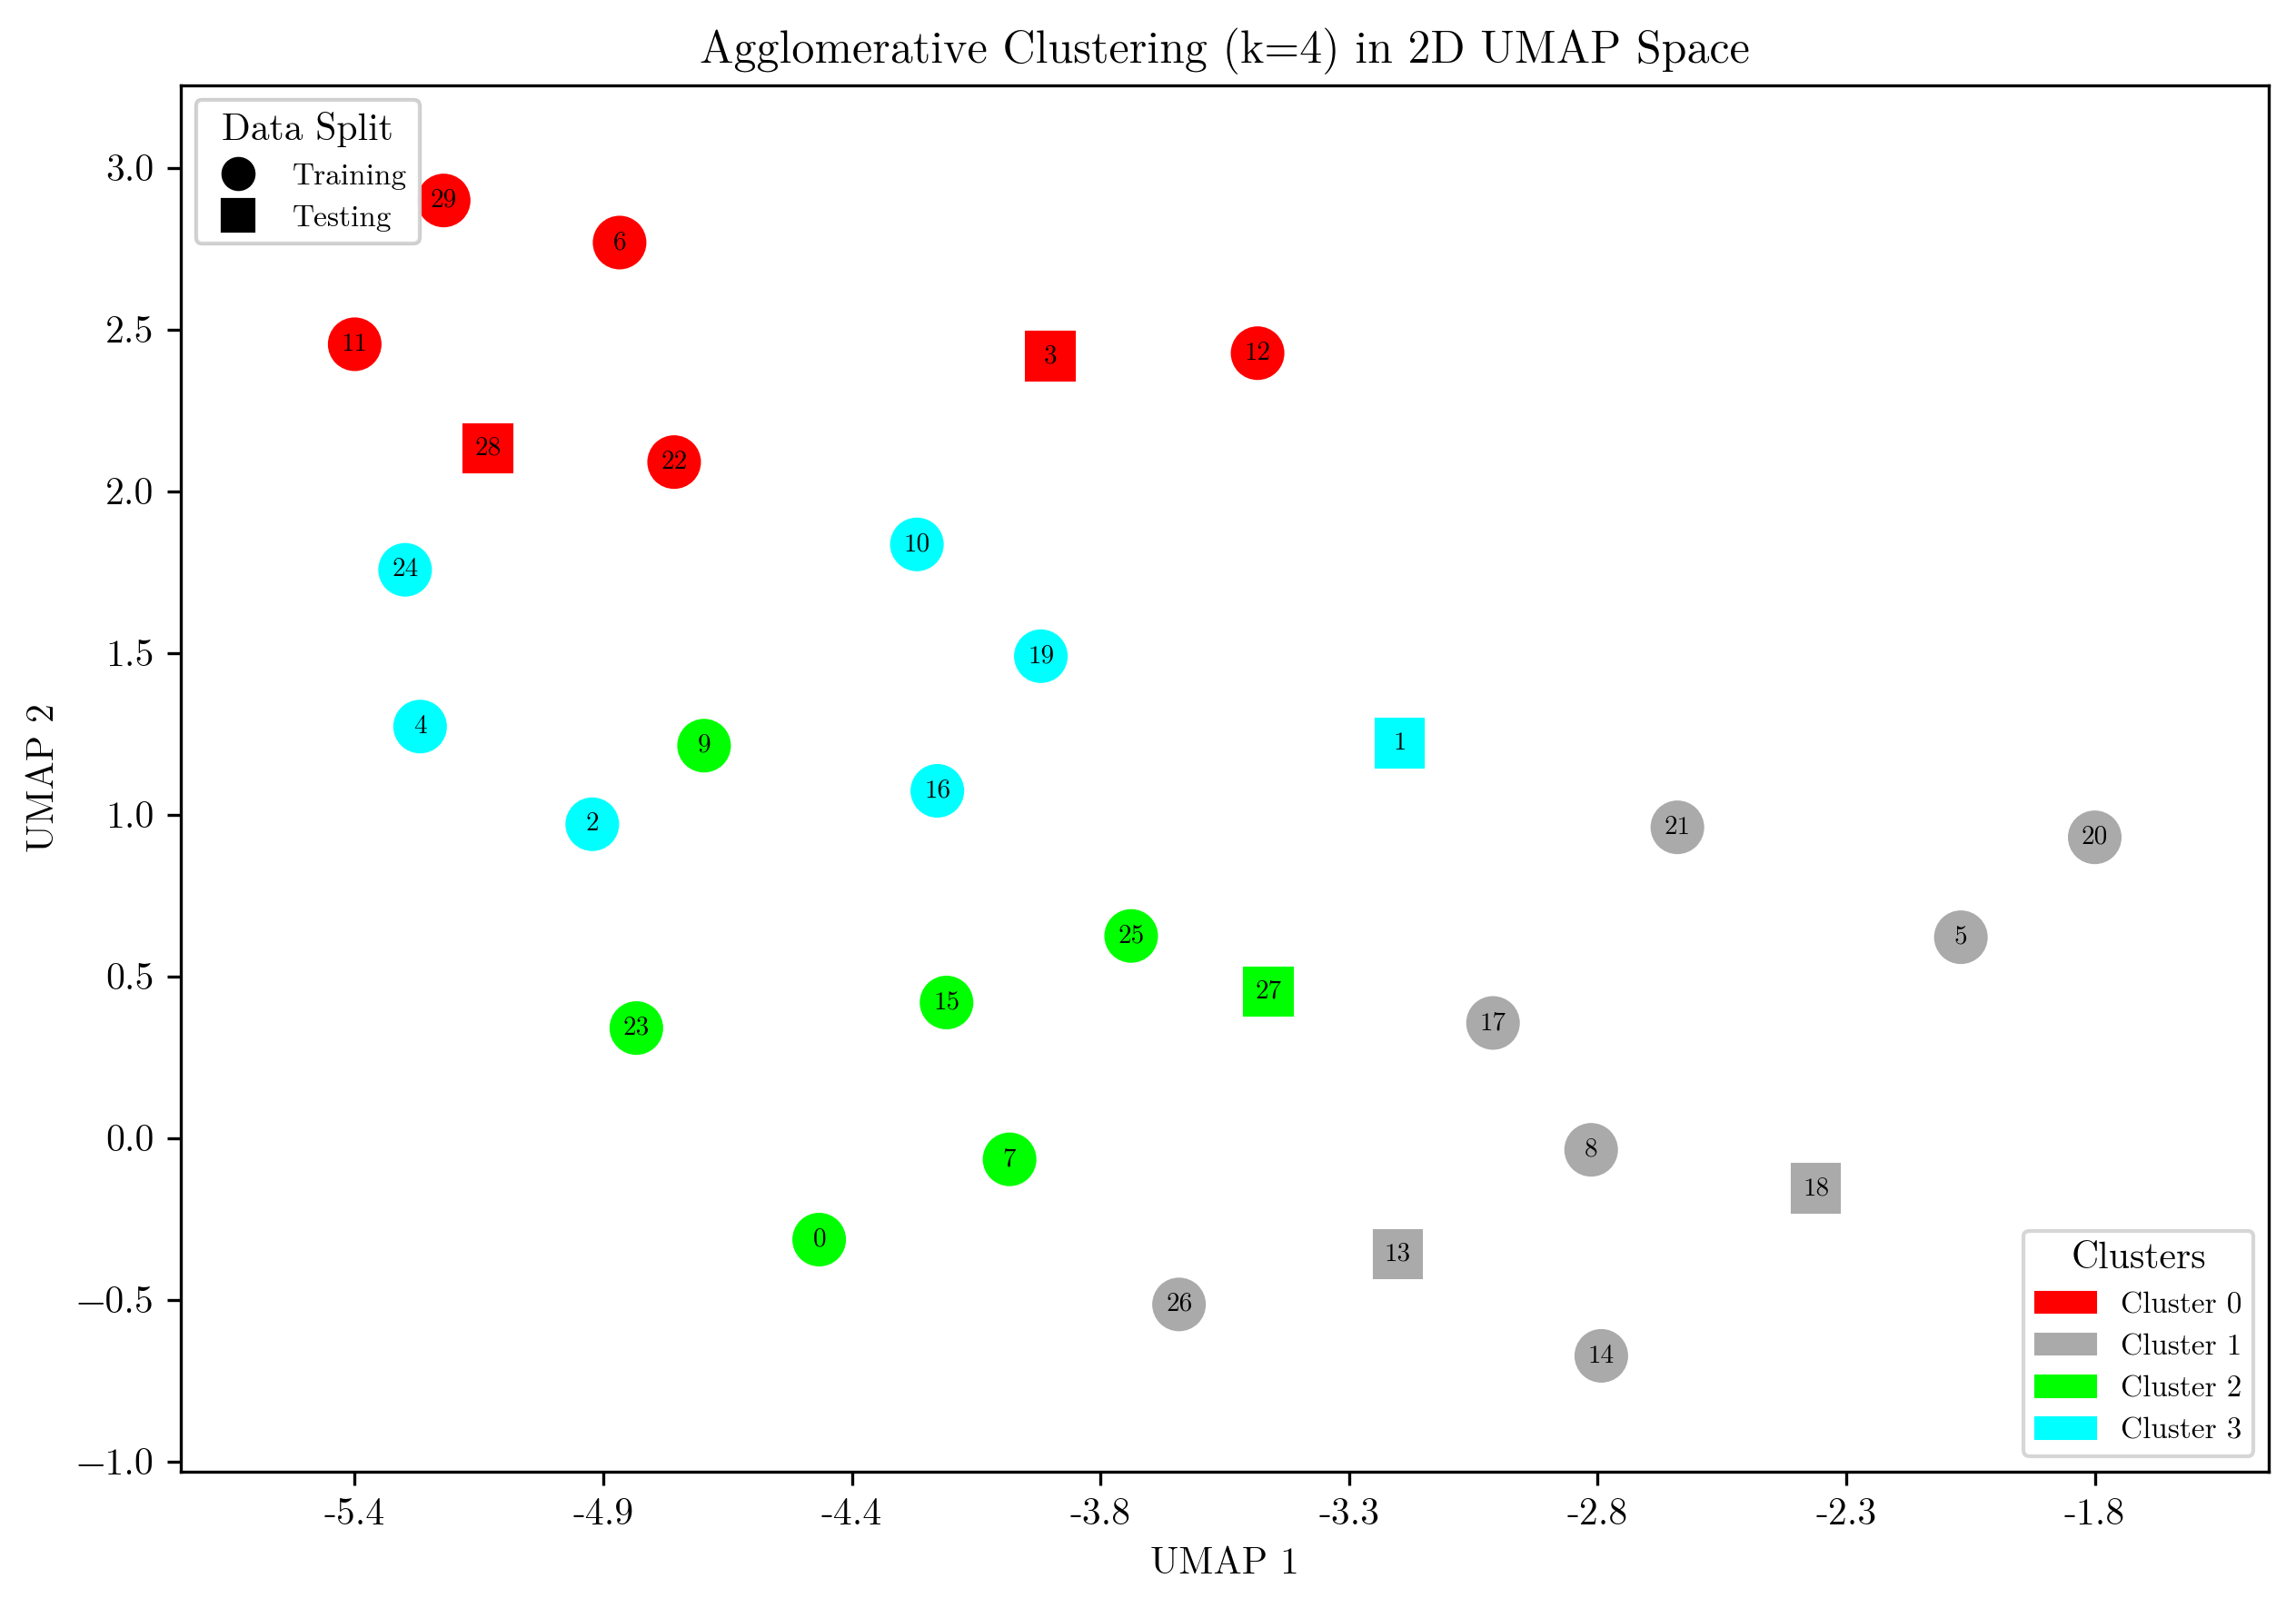

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Patch
from matplotlib.lines import Line2D
import numpy as np
import umap
from sklearn.cluster import AgglomerativeClustering

# UMAP dimensionality reduction
umap_2d = umap.UMAP(n_components=2, random_state=0)
X_2d = umap_2d.fit_transform(features_scaled)

# Stretch factor for X-axis (visual only)
x_stretch_factor = 1.5
X_plot = X_2d.copy()
X_plot[:, 0] *= x_stretch_factor  # Stretch only X values

# Cluster setup
final_k = 4
base_colors = ['#FF0000', '#AAAAAA', '#00FF00', '#00FFFF', '#AA00FF']
fill_styles = ['solid', 'hatch1', 'hatch2']
hatch_patterns = {'solid': None, 'hatch1': '/////', 'hatch2': 'xxxx'}

# Cluster model
model = AgglomerativeClustering(n_clusters=final_k)
labels = model.fit_predict(features_reduced)

# Masks
is_train = agg_features.index.isin(train_video_ids)

# Plot setup
fig, ax = plt.subplots(figsize=(20, 6), dpi=300)

label_offsets = {
}

for i in range(len(X_plot)):
    label = labels[i]
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]
    x, y = X_plot[i]

    if agg_features.index[i] in train_video_ids:
        marker = Circle((x, y), radius=0.08,
                        facecolor=color if hatch is None else 'white',
                        edgecolor=color, hatch=hatch,
                        linewidth=0.5, alpha=1)
    else:
        size = 0.15
        marker = Rectangle((x - size / 2, y - size / 2), width=size, height=size,
                           facecolor=color if hatch is None else 'white',
                           edgecolor=color, hatch=hatch,
                           linewidth=0.5, alpha=1)
    ax.add_patch(marker)

    video_id = agg_features.index[i]
    dx, dy = label_offsets.get(video_id, (0.0, 0.0))
    ax.text(x + dx, y + dy, str(video_id), fontsize=7, ha='center', va='center', color='black')

# Axes labels and title
ax.set_title(f'Agglomerative Clustering (k={final_k}) in 2D UMAP Space')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

# Axis limits (on stretched x-axis)
x_vals = X_plot[:, 0]
y_vals = X_plot[:, 1]
x_margin = (x_vals.max() - x_vals.min()) * 0.1
y_margin = (y_vals.max() - y_vals.min()) * 0.1
ax.set_xlim(x_vals.min() - x_margin, x_vals.max() + x_margin)
ax.set_ylim(y_vals.min() - y_margin, y_vals.max() + y_margin)

# Equal aspect, to keep shapes undistorted
ax.set_aspect('equal', adjustable='box')

# Custom tick labels to show original (unscaled) X values
xticks = np.linspace(x_vals.min(), x_vals.max(), num=8)
xticklabels = [f"{x / x_stretch_factor:.1f}" for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# --- Legend 1: Cluster Colors & Patterns ---
legend_elements = []
for label in np.unique(labels):
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]
    legend_elements.append(Patch(
        facecolor=color if hatch is None else 'white',
        edgecolor=color,
        hatch=hatch,
        label=f'Cluster {label}',
        linewidth=0.5
    ))

legend1 = ax.legend(
    handles=legend_elements,
    title='Clusters',
    fontsize=8,
    loc='lower right',
    frameon=True
)
ax.add_artist(legend1)

# --- Legend 2: Data Split (Train/Test) ---
marker_handles = [
    Line2D([0], [0], marker='o', color='black', label='Training',
           markersize=8, linestyle='None'),
    Line2D([0], [0], marker='s', color='black', label='Testing',
           markersize=8, linestyle='None')
]
legend2 = ax.legend(
    handles=marker_handles,
    title='Data Split',
    fontsize=8,
    loc='upper left',
    frameon=True
)
ax.add_artist(legend2)

plt.tight_layout()
plt.show()


In [16]:
df_split = video_cluster_df.copy()

# Add 'split' column based on train/test membership
df_split['split'] = df_split['video_number'].apply(
    lambda x: 'train' if x in train_video_ids else 'test'
)
df_split['video_number'] = df_split['video_number'].apply(lambda x: f'{x:03d}_10s')

df_split.to_csv('60s_video_splits.csv', index=False)
